# Mode d'emploi sur l'utilisation de la librairie

#### Import des sous modules de la librairie

In [18]:
from kernel.tools import CalendarConvention, ObservationFrequency
from kernel.market_data import InterpolationType, VolatilitySurfaceType, Market, RateCurveType

In [19]:
from kernel.products.options.vanilla_options import EuropeanCallOption
from kernel.models import EulerSchemeType, PricingEngineType
from kernel.pricing_launcher import PricingLauncher
import numpy as np
import pandas as pd
from scipy.stats import norm

#### Informations renseignées par l'utilisateur (sur l'interface)

In [20]:
security = "S&P500"
rate_curve_type = RateCurveType.RF_US_TREASURY
interpolation_type = InterpolationType.SVENSSON
volatility_surface_type = VolatilitySurfaceType.SVI
calendar = CalendarConvention.ACT_360
scheme = EulerSchemeType.EULER
obs_frequency = ObservationFrequency.ANNUAL
pricer_type = PricingEngineType.MC

#### Initialisation du marché

In [21]:
market = Market(underlying_name=security, rate_curve_type=rate_curve_type, interpolation_type=interpolation_type, 
                volatility_surface_type=volatility_surface_type, calendar_convention=calendar)

#### Initialisation du pricer et du produit à pricer

In [22]:
call_option = EuropeanCallOption(maturity=2, strike=market.underlying_asset.last_price)
launcher = PricingLauncher(market=market, nb_paths=100000, nb_steps=1, discretization_method=scheme, pricer_type=pricer_type)

#### Pricing

In [23]:
price = launcher.price(call_option)
print(price)

680.1305268490445


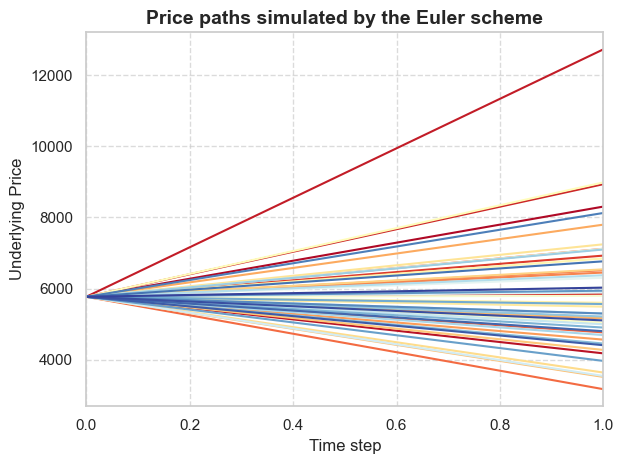

In [24]:
launcher.pricer.plot_paths(call_option, nb_paths_plot=50)

#### Pricing with stochastic volatility

In [25]:
scheme = EulerSchemeType.HESTON_EULER
launcher = PricingLauncher(market=market, nb_paths=10000, nb_steps=25, discretization_method=scheme, pricer_type=pricer_type)

In [26]:
price = launcher.price(call_option)
print(price)

998.6442890841848


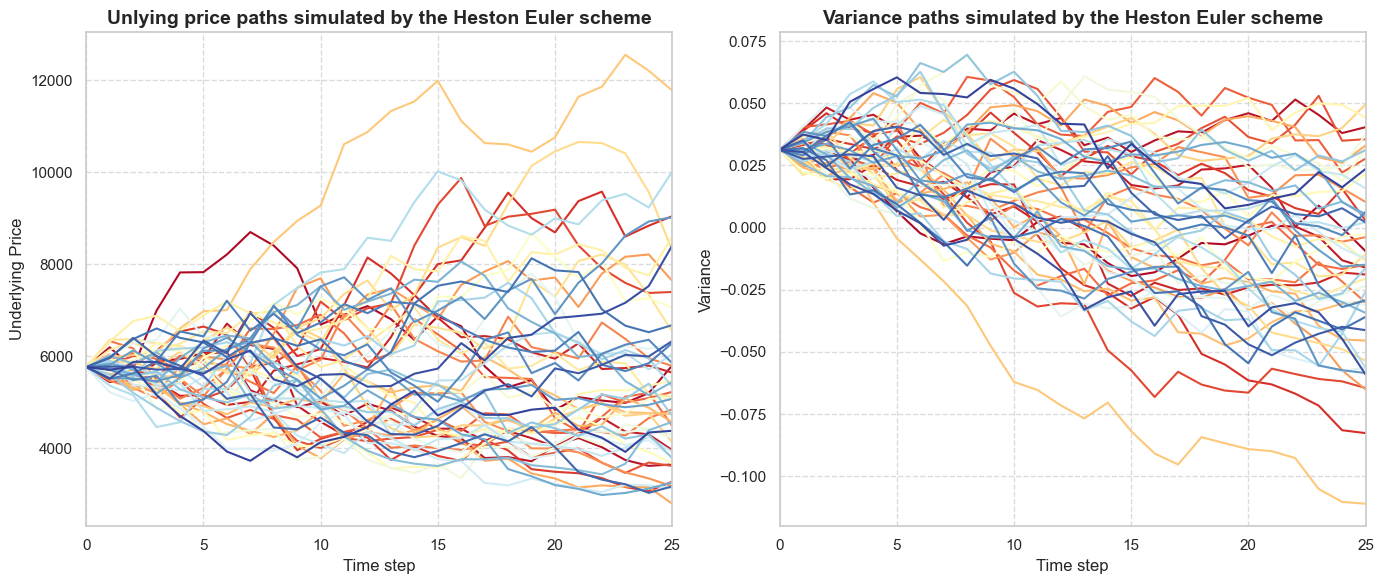

In [27]:
launcher.pricer.plot_paths(call_option, nb_paths_plot=50, plot_variance=True)

#### Calcul des grecques

In [28]:
greeks = launcher.pricer.compute_greeks(call_option)
print(greeks)

        Delta  Gamma  Vega  Theta  Rho
Greeks    0.0    0.0   0.0    0.0  0.0


c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\volatility_surface\svi_volatility.py:176: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(total_variance / maturity) / 100


#### Comparaison avec la formule fermée

In [29]:
def black_scholes(S, K, T, sigma, option_type="call"):
    """
    Calcule le prix d'une option européenne avec le modèle Black-Scholes.

    :param S: Prix actuel du sous-jacent
    :param K: Strike (prix d'exercice)
    :param T: Temps jusqu'à l'expiration en années
    :param sigma: Volatilité implicite
    :param option_type: "call" ou "put"
    :return: Prix de l'option
    """
    r = market.get_rate(T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # Put
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return price

In [30]:
closed_form_price = black_scholes(S=market.underlying_asset.last_price, K=call_option.strike, 
                                  T=call_option.maturity, sigma=market.get_volatility(call_option.strike, call_option.maturity))
print(closed_form_price)

680.7263196881572


## --------------------------------------------------------------------------------------------------

#### Exemples d'utilisation des informations stockées dans le marché

In [31]:
print(f"Taux 1.2Y interpolé: {round(market.get_rate(1.2),2)}%")
print(f"Volatilité K=220, T=24 jours interpolée: {round(market.get_volatility(call_option.strike, 1.2),2)}%")

Taux 1.2Y interpolé: 0.02%
Volatilité K=220, T=24 jours interpolée: 0.17%


#### Visualisation de l'interpolation de la courbe de taux

c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve_data\interpolators\svensson_interpolator.py:46: RuntimeWarning: invalid value encountered in scalar divide
  term1 = beta1 * (1 - np.exp(-t / tau1)) / (t / tau1)
c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve_data\interpolators\svensson_interpolator.py:47: RuntimeWarning: invalid value encountered in scalar divide
  term2 = beta2 * ((1 - np.exp(-t / tau1)) / (t / tau1) - np.exp(-t / tau1))
c:\Users\thibc\OneDrive\Documents\Dev\Structured-Product-Pricing-Python\kernel\market_data\rate_curve_data\interpolators\svensson_interpolator.py:48: RuntimeWarning: invalid value encountered in scalar divide
  term3 = beta3 * ((1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2))


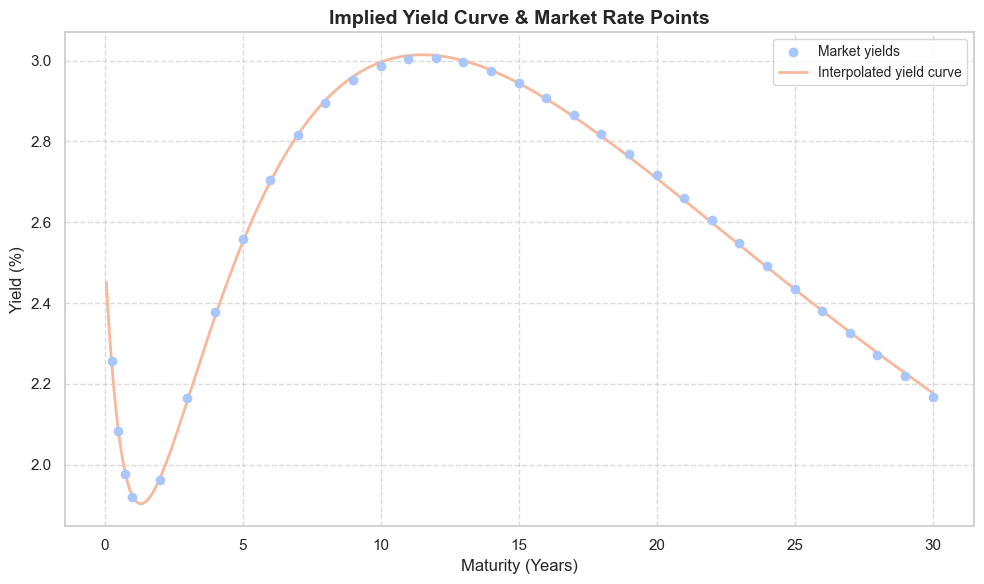

In [32]:
market.rate_curve.display_curve()

#### Visualisation de la surface de volatilité

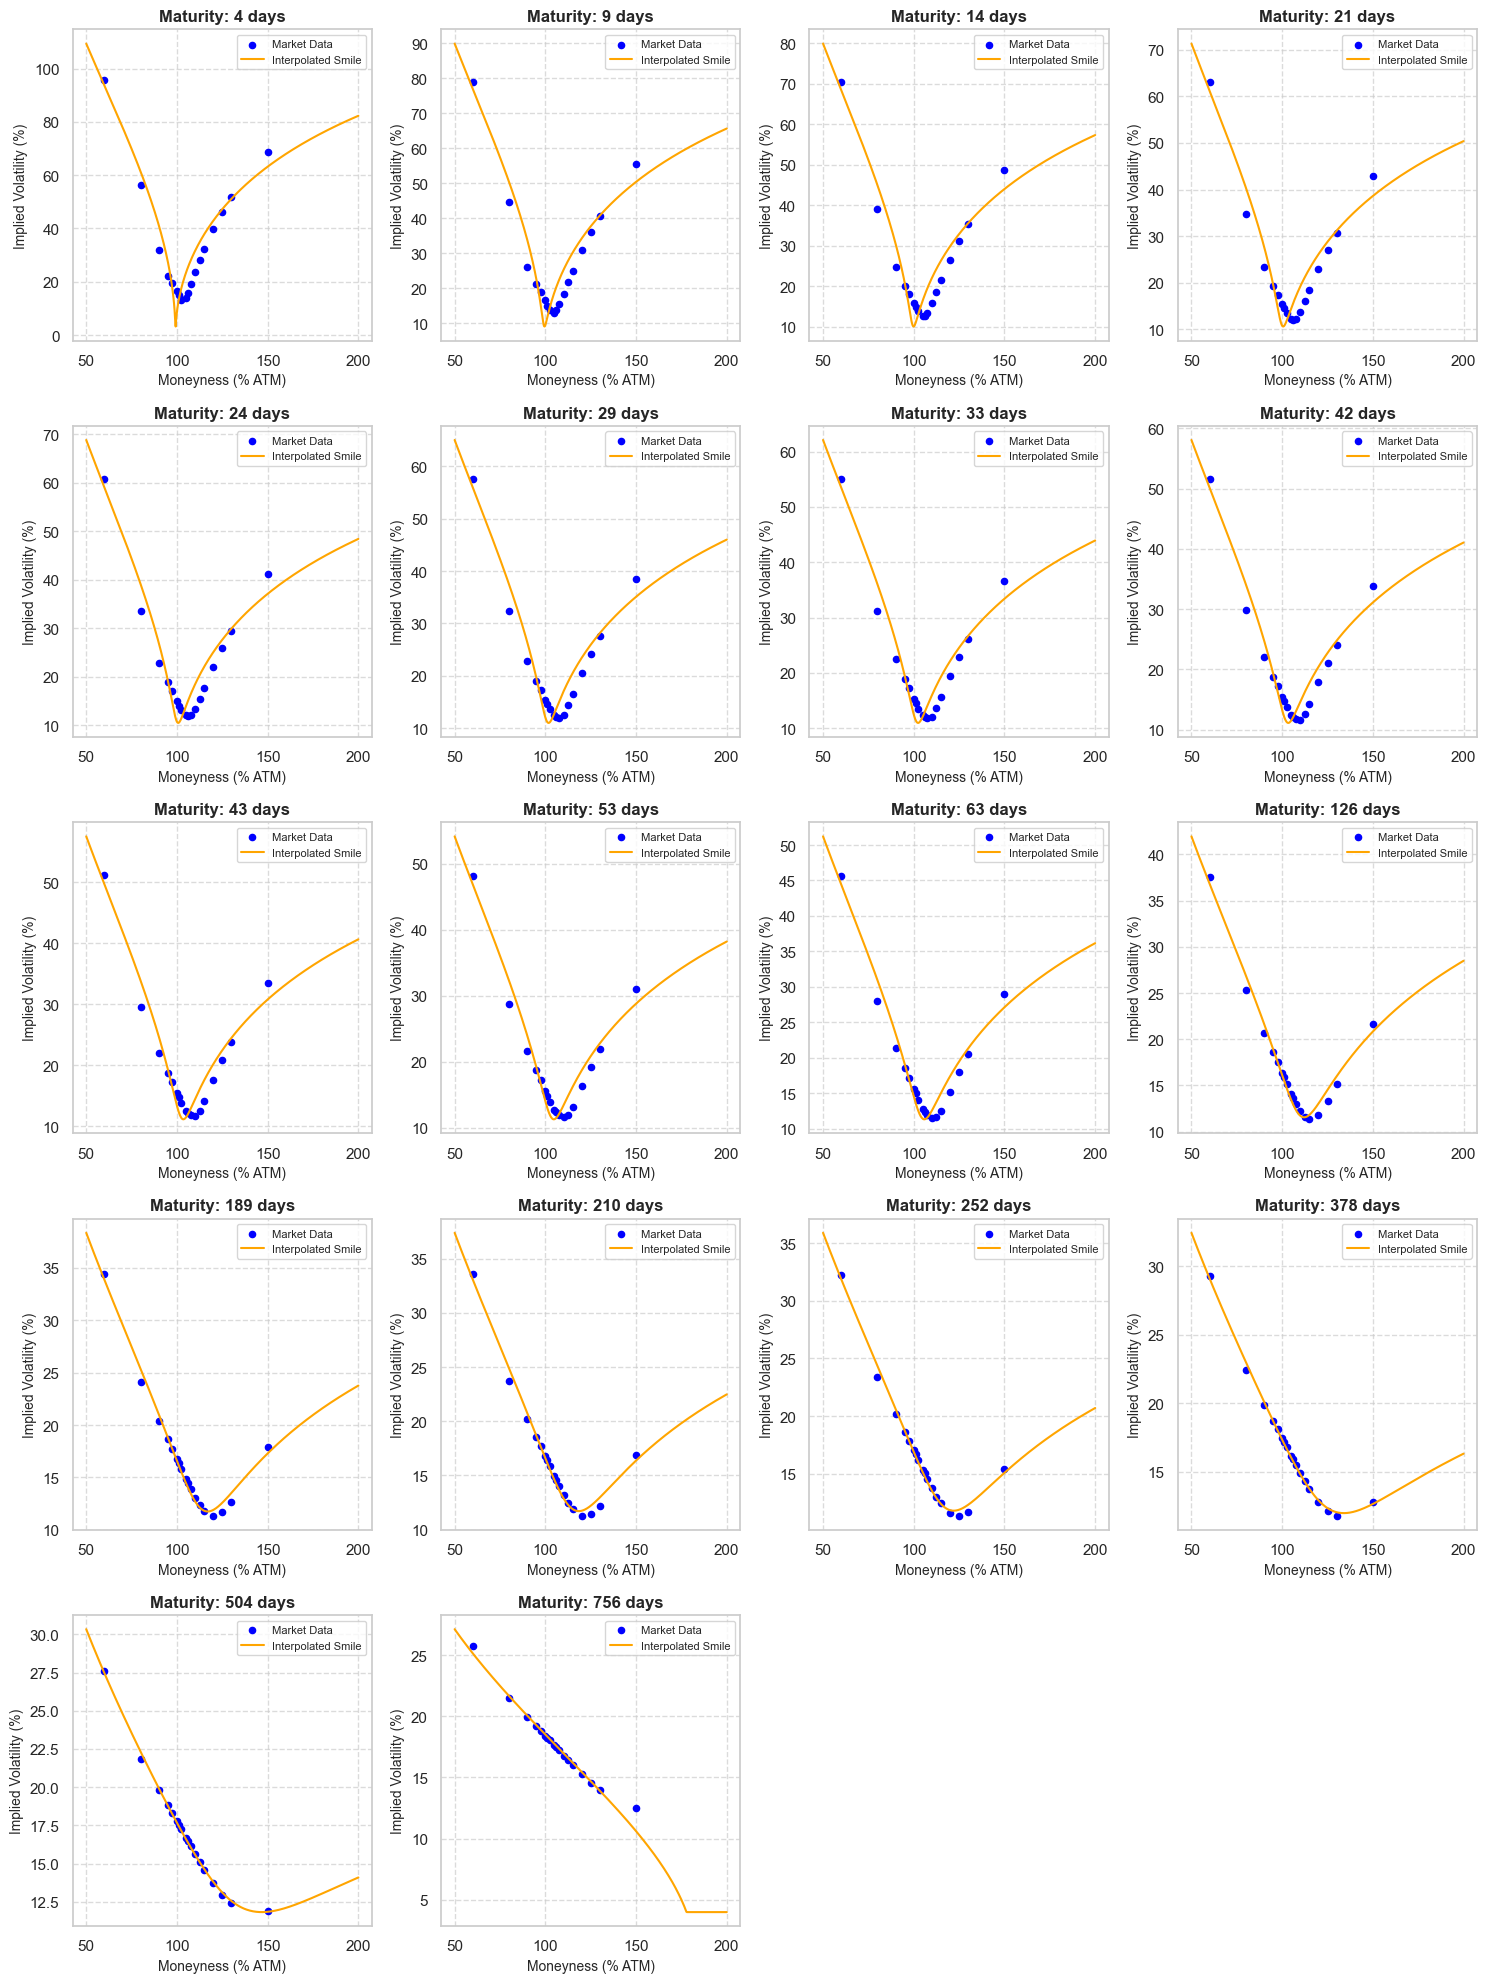

In [33]:
market.volatility_surface.display_smiles()

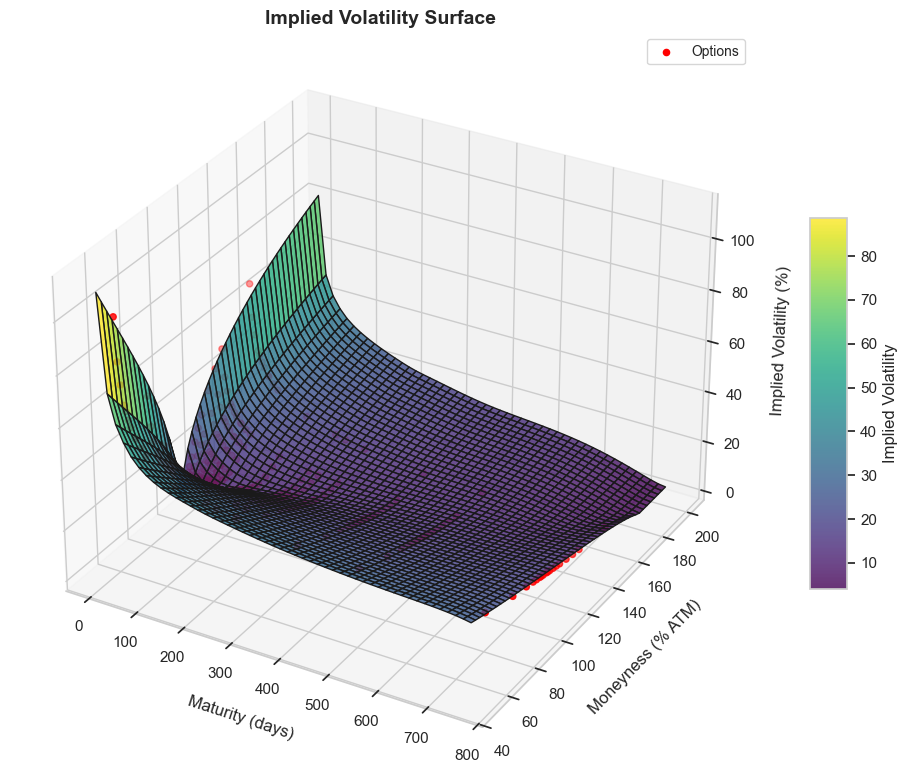

In [34]:
market.volatility_surface.display_surface()